In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import xarray

import stats 

In [30]:
import inspect
lines = inspect.getsource(stats.compute_xcor_nd)
print(lines)

def compute_xcor_nd(Z1, Z2, lag=0, tau=None):
    """
    Empirical cross-correlation broadcasted over an array
    Cressie and Wikle, Eq 5.4, single location.
    Inputs:
        - Z1, Z2: xarray data array (lon x lat x time)
        - lag: integer lag
        - tau: integer threshold indicating minimum number of values needed for a valid computation
    Outputs:
        - xcor: xarray data array (lon x lat)
    """
    # apply mask for nan values
    Z1_m = np.ma.array(Z1, mask=np.isnan(Z1))
    Z2_m = np.ma.array(Z2, mask=np.isnan(Z2))

    # remove the mean along time dim
    X = Z1_m - Z1_m.mean(axis=-1, keepdims=True)
    Y = Z2_m - Z2_m.mean(axis=-1, keepdims=True)
    if lag is not 0:
        # truncate along time dim at appropriate position to apply lag
        X = X[:, :, lag:]
        Y = Y[:, :, :-lag]

    # compute cross-correlation along the time dimension
    xcor = np.sum(X * Y, axis=-1) / (
        np.sqrt(np.sum(X * X, axis=-1)) * np.sqrt(np.sum(Y * Y, axis=-1))
    

In [5]:
def gen_1d_arr(N):
    # Create a random 1-d array with ~1/3 of the entries missing
    idx = np.random.choice(np.arange(N), size=int(N / 2 + 20), replace=False)
    X = np.random.rand(N)
    X[idx] = np.nan
    return X

def gen_nd_arr(N):
    # Create a random 3-d array with ~1/3 of the entries missing
    idx = np.random.choice(np.arange(N**3), size=int(N**3 / 2  + N**2), replace=False)
    X = np.random.rand(N**3)
    X[idx] = np.nan
    return X.reshape(N, N, N)

In [31]:
X = gen_nd_arr(100)

DS = xarray.Dataset(
    {
        "sif": (["lon", "lat", "time"], X),
        "xco2": (["lon", "lat", "time"], X),
    },
    coords = {
        "lon": (["lon"], np.arange(100)),
        "lat": (["lat"], np.arange(100)),
        "time": (["time"], np.arange(100)),
    }
)

DS

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 100, time: 100)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sif      (lon, lat, time) float64 0.4808 0.5546 0.0194 ... nan 0.1317 nan
    xco2     (lon, lat, time) float64 0.4808 0.5546 0.0194 ... nan 0.1317 nan

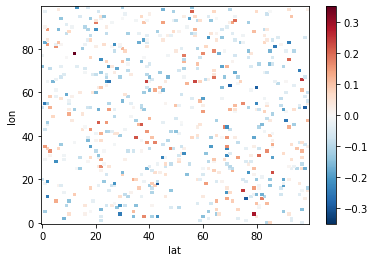

In [33]:
xcor = stats.apply_xcor(DS.xco2, DS.sif, lag=10, tau=30)
xcor.plot()

In [34]:
print(xcor.min(), xcor.max())

<xarray.DataArray ()>
array(-0.29732768) <xarray.DataArray ()>
array(0.35149239)


In [37]:
# NOTE: this is different from the above in that trend is not removed
xcor = stats.compute_xcor_nd(DS.xco2, DS.sif, lag=10, tau=30)

In [38]:
print(np.nanmin(xcor), np.nanmax(xcor))

-0.29444132523050953 0.36539887840477087


In [46]:
# TODO: extract data where max and min are outside range

# Check the 1-d case
x_list = [gen_1d_arr(100) for _ in range(1000)]

xcor = np.array([stats.compute_xcor_1d(x, x, lag=10, tau=10) for x in x_list])
# xcor

In [47]:
print(np.nanmin(xcor), np.nanmax(xcor))

-0.4462836615263968 0.26431596451083295
